# Visualisation

Displaying usable/interesting information from 400 000 pairs of questions is not a piece of cake...

Note we will work only on training data.

In [1]:
# Ugly incantation to make our framework working
import sys
sys.path.insert(0, r'/SAPDevelop/QuoraPairs/BruteForce/Tools')

#import all our small tools (paths, cache, print,zip,excel, pandas, progress,..)
from Tools.all import *

# setup the name of our experiment
# it will be used to store every result in a unique place
EXPERIMENT='visualisation'
print_alert('You will work on experiment %s' %EXPERIMENT)

prepare_environnement(EXPERIMENT)
train_dataframe=load_dataframe(CLEAN_TRAINING_DATA)
challenge_dataframe=load_dataframe(CLEAN_CHALLENGE_DATA)
print_section('Untouched input data has been loaded. Training: %d lines Challenge: %d lines' % (len(train_dataframe),len(challenge_dataframe)))

## First steps
* load our best dataset
* Do some manual browsing
* Apply kind of brute force : show wordcloud on the whole dataset

In [2]:
# our main tool to add feature
def add_column_from_columns(dataframe,output_column_name,function):
    dataframe[output_column_name]=dataframe.progress_apply(function,axis=1)
    return dataframe[output_column_name]

def add_column_from_column(dataframe,output_column_name,input_column_name,function):
    dataframe[output_column_name]=dataframe[input_column_name].progress_apply(function)
    return dataframe[output_column_name]

# This will get back the name of the newsgroup with maximum proba for both questions
NEWSGROUP_LABELS=[
    'religion', #0
    'computers', #1
    'forsale', #2
    'vehicles', #3
    'sport', #4
    'science', #5
    'politics', #6
]

def find_best_newsgroup(r):
    probas = [r['proba_'+c+'_question1'] for c in NEWSGROUP_LABELS]
    max_idx_1 = numpy.argsort(probas)[-1]
    max_1 = probas[max_idx_1]

    probas = [r['proba_'+c+'_question2'] for c in NEWSGROUP_LABELS]
    max_idx_2 = numpy.argsort(probas)[-1]
    max_2 = probas[max_idx_2]  
    return (max_1,NEWSGROUP_LABELS[max_idx_1],max_2,NEWSGROUP_LABELS[max_idx_2])

def glue_all_domains(unused,dataset_name):
    # Bootstrap with our last full save
    print_warning('Load basic+nltk_stop_words+all_stop_words+clean_all_stop_words_features')
    dataframe = load_global_dataframe(dataset_name+'_clean_all_stop_words_features')
    
    print_warning('Glue lemmatized questions')
    lemmatized_questions = load_global_dataframe(dataset_name+'_lemmatized')
    dataframe['lemmatized_question1'] = lemmatized_questions['question1']
    dataframe['lemmatized_question2'] = lemmatized_questions['question2']
    del lemmatized_questions

    lemmatized_entities = load_global_dataframe(dataset_name+'_final_lemmatized_entities_features')
    print_warning('Glue lemme features & entities')
    # The set_index option was specially tricky. Made me mad for a while
    dataframe = pandas.concat([dataframe,lemmatized_entities.set_index(dataframe.index)],axis=1)
    del lemmatized_entities

    print_warning('Glue entities of interest')
    entities =   load_global_dataframe(dataset_name+'_entities')
    entities = entities[[c for c in entities.columns if 'ratio' not in c and 'nb' not in c and 'question' in c and c not in ['question1','question2']]]
    dataframe = pandas.concat([dataframe,entities.set_index(dataframe.index)],axis=1)
    del entities

    print_warning('Glue newsgroups')
    newsgroup_proba = load_global_dataframe(dataset_name+'_newsgroup_proba') 
    #we get back best newsgroup and its proba for both questions
    print_warning('find best newsgroups')
    add_column_from_columns(newsgroup_proba,'tmp',find_best_newsgroup)
    add_column_from_column(newsgroup_proba,'proba_newsgroup_1','tmp',lambda t: t[0])
    add_column_from_column(newsgroup_proba,'newsgroup_1','tmp',lambda t: t[1])
    add_column_from_column(newsgroup_proba,'proba_newsgroup_2','tmp',lambda t: t[2])
    add_column_from_column(newsgroup_proba,'newsgroup_2','tmp',lambda t: t[3])
    dataframe[['proba_newsgroup_1','newsgroup_1','proba_newsgroup_2','newsgroup_2']] = newsgroup_proba[['proba_newsgroup_1','newsgroup_1','proba_newsgroup_2','newsgroup_2']]
    del newsgroup_proba

    
    # remove plenty of useless columns : we look only text and maybe 2 probas
    dataframe=dataframe.drop(columns=[c for c in all_numeric_columns(dataframe) if 'newsgroup' not in c])

    return dataframe

In [3]:
train_dataframe = load_or_build_dataframe('Prepare data for training visualisation','train_visu',glue_all_domains,None,param1='train')
# not really useful here ...
challenge_dataframe = load_or_build_dataframe('Prepare data for training visualisation','challenge_visu',glue_all_domains,None,param1='challenge')


What do we have as textual data ?

In [4]:
ALL_STRING_COLUMNS=[c for c in train_dataframe.columns if train_dataframe.dtypes[c] not in ['int64','float64']]
ALL_NUMERIC_COLUMNS=all_numeric_columns(train_dataframe)
print_section('All string columns')
print_info(str(ALL_STRING_COLUMNS))
print_section('All numeric columns')
print_info(str(ALL_NUMERIC_COLUMNS))


# describe ALL_STRING_COLUMNS takes HOURS...
# Mandatory to cache it !!
#train_dataframe[ALL_STRING_COLUMNS].describe()
#train_describe = load_or_build_dataframe('Build naive description of train','train_describe',lambda d: d.describe(),train_dataframe[ALL_STRING_COLUMNS])

# Better to describe one column at a time
train_dataframe[['question1','question2']].describe()


question1                                                                        question2
count                  404290                                                                           404290
unique                 290371                                                                           299086
top     how do i lose weight?  how can you look at someone's private instagram account without following them?
freq                       69                                                                              120

Looks like loosing weight is high priority as well as instagram stalkers 

In [5]:
train_dataframe[train_dataframe['question1']=='how do i lose weight?'][['question2','is_duplicate']]

question2  is_duplicate
1806                          how do i suck it up and lose weight?             1
2881                   how can i lose weight slowly and naturally?             1
4394    i'm 12 and at 60 kg and about 144 cm how do i lose weight?             1
8383                              what can i do to lose 20 pounds?             1
13494                           what should i do to reduce weight?             1
...                                                            ...           ...
368708                 how can i lose an extreme amount of weight?             1
374026                              how do i actually lose weight?             1
386807                       what are the best was to lose weight?             1
389671             i'm overweight. how can i begin to lose weight?             1
403040                                how do i reduce body weight?             1

[69 rows x 2 columns]

In [6]:
train_dataframe[train_dataframe['question2']=="how can you look at someone's private instagram account without following them?"][['is_duplicate','question1']]

is_duplicate                                                                                                                                                       question1
16138              0  if i link my instagram account to my facebook account, will my friends from facebook be able to see the photos i post even if my instagram account is private?
16183              0                                                                                                          can you view pictures on instagram without an account?
17232              0                                                                                                                          how many oriya girls wear mini skirts?
20239              0                                                                                                                                           why did symbian fail?
22376              0                                                                                                          how do i see followers on someone's private instagram?
...              ...                                                                                                                                                             ...
383291             0                                                                                                                                             why does love hurt?
387709             0                                                                                                                              how do i hide instagram followers?
390738             0                                                                                                            are pakistani girls allowed to wear skirt in public?
400857             0                                                                                                        cars (2006 movie): what mark/model is lightning mcqueen?
401146             0                                                                                                                   how do i unfollow people faster on instagram?

[120 rows x 2 columns]

Even the first lines show possible subjects are very different

In [7]:
train_dataframe[['question1','question2']].head(5).transpose()

0                                                                                         1  \
question1  what is the step by step guide to invest in share market in india?                                       what is the story of kohinoor (koh-i-noor) diamond?   
question2           what is the step by step guide to invest in share market?  what would happen if the indian government stole the kohinoor (koh-i-noor) diamond back?   

                                                                                   2                                                                  3  \
question1  how can i increase the speed of my internet connection while using a vpn?                 why am i mentally very lonely? how can i solve it?   
question2                how can internet speed be increased by hacking through dns?  find the remainder when [math]23^{24}[/math] is divided by 24,23?   

                                                                                      4  
question1  which one dissolve in water quikly sugar, salt, methane and carbon di oxide?  
question2                                       which fish would survive in salt water?

## Try to a get global view

1. Load a large list of stop words

In [8]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

nltk_stopwords = set(stopwords.words('english'))
sk_stopwords = set(ENGLISH_STOP_WORDS)
print_info('There is %d words in nltk stop words' % len(nltk_stopwords))
print_info('There is %d words in sklearn stop words' % len(sk_stopwords))
new_stopwords = [w for w in sk_stopwords if w not in nltk_stopwords]
print_info('There is %d new stop words in sklearn stop words' % len(new_stopwords))

all_stop_words = nltk_stopwords | sk_stopwords
print_info('There is %d words in the union of stop words' % len(all_stop_words))

2. Display a word cloud on question1
* stop words are suppressed
* words must be at least 5 chars
* display the most common words
* the more frequent, the biggest the word is

(-0.5, 1439.5, 1079.5, -0.5)

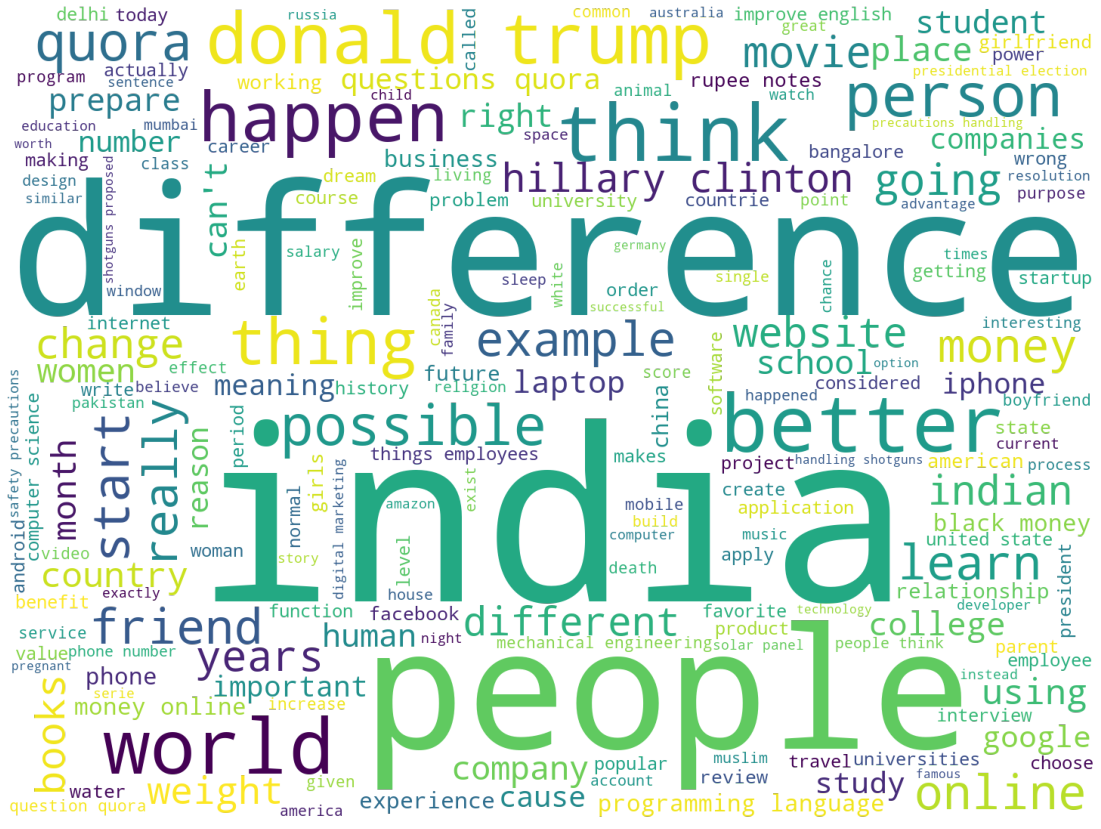

In [9]:
from wordcloud import WordCloud
cloud = WordCloud(
    width=1440,
     height=1080,
     stopwords=all_stop_words,
     background_color=None,
     mode='RGBA',
     relative_scaling=1,
     min_word_length=5
     ).generate(" ".join(train_dataframe['question1']))
plot.figure(figsize=(20, 15))
plot.imshow(cloud)
plot.axis('off')

Quite heavy
* India : quora is very used in India
* Donald Trump, Hillary Clinton : dataset is from 2017

Still, difficult to see something useful

We worked on unclean text, without lemmes. Maybe, it will be more easy to interpret with clean and lemmatized text...

(-0.5, 1439.5, 1079.5, -0.5)

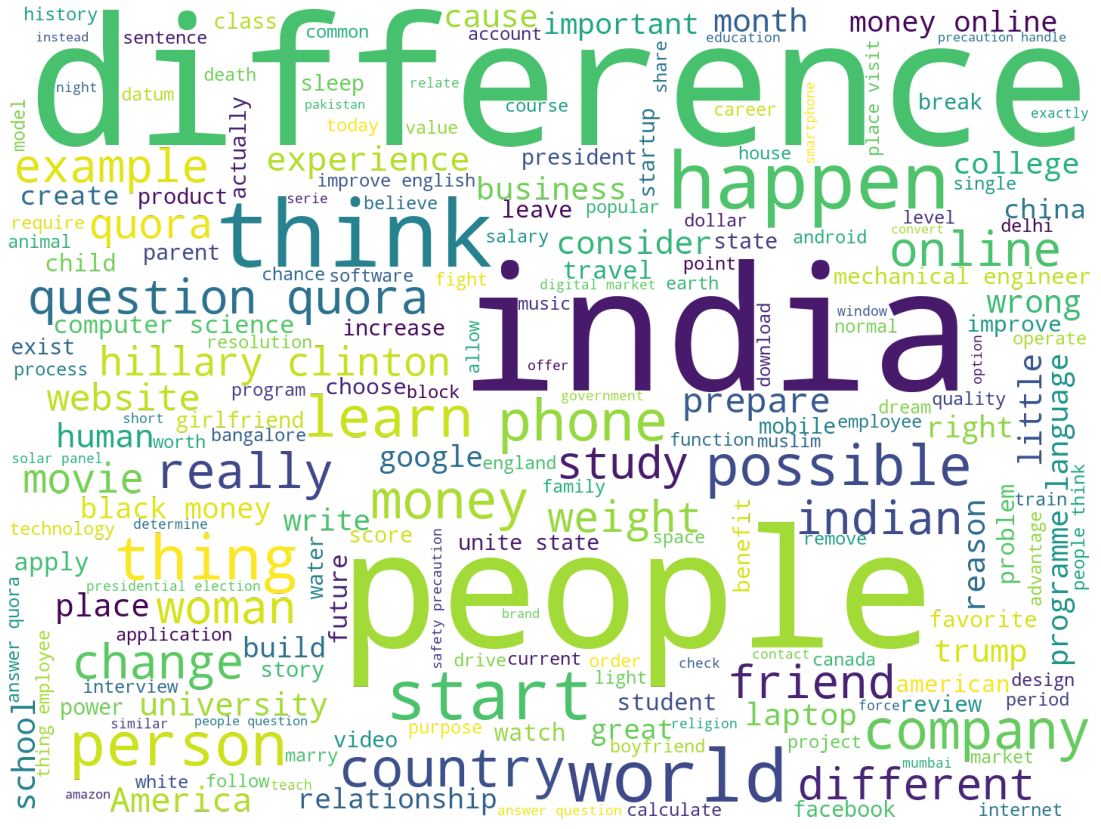

In [10]:
cloud = WordCloud(
    width=1440,
     height=1080,
     stopwords=all_stop_words,
     background_color=None,
     mode='RGBA',
     relative_scaling=1,
     min_word_length=5
     ).generate(" ".join(train_dataframe['lemmatized_question1']))
plot.figure(figsize=(20, 15))
plot.imshow(cloud)
plot.axis('off')

Not dramatically better ...
Can we compare with vocabulary used by challenge dataset?

(-0.5, 1439.5, 1079.5, -0.5)

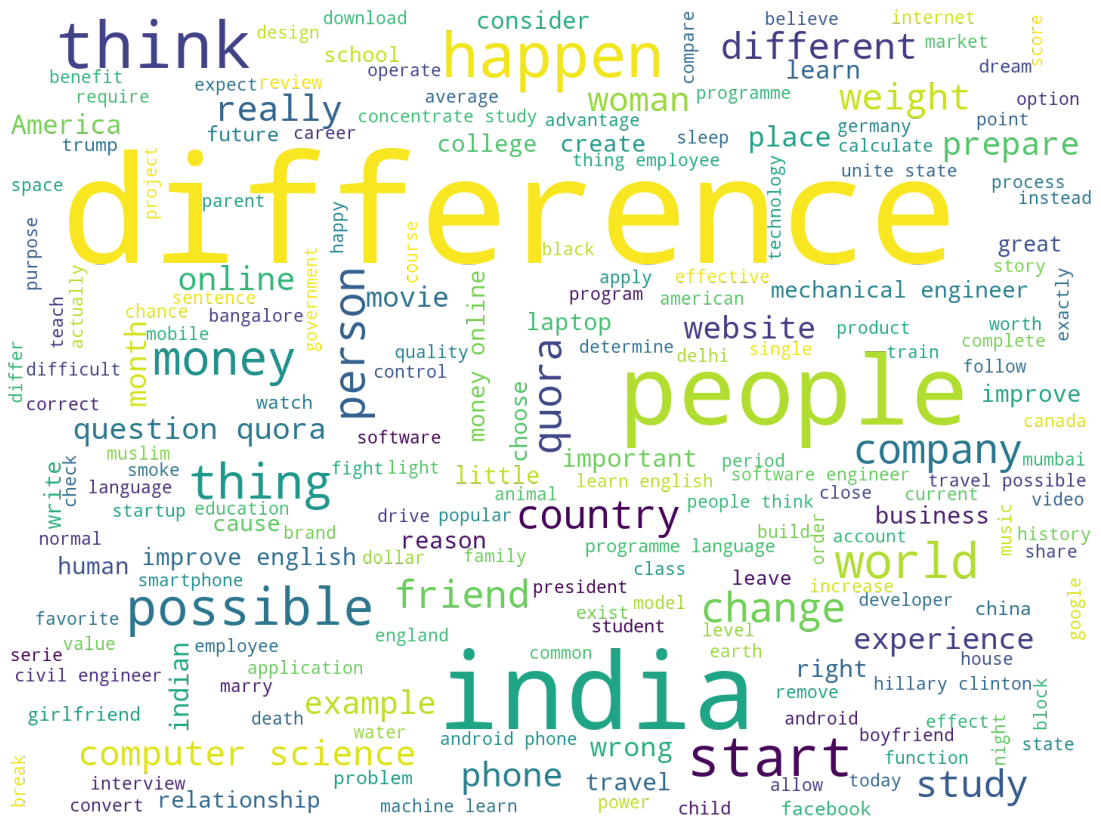

In [11]:
cloud = WordCloud(
    width=1440,
     height=1080,
     stopwords=all_stop_words,
     background_color=None,
     mode='RGBA',
     relative_scaling=1,
     min_word_length=5
     ).generate(" ".join(challenge_dataframe['lemmatized_question1']))
plot.figure(figsize=(20, 15))
plot.imshow(cloud)
plot.axis('off')

Looks like vocabulary is the same. But we are still overdrawned

One way would be to filter more data by focusing on some subject before displaying a wordcloud

We have the newsgroup information available in our dataset:
* partial information: we have only this information for 7 topics:
    * religion,computers,forsale,vehicles,sport,science,politics
* partial information : this info is coming from a predictive model (80% accuracy)

What happen if we apply a threshold of 0.5 (quite confident in newsgroup prediction)

In [12]:
train_dataframe[train_dataframe['proba_newsgroup_1']>0.5][['question1','newsgroup_1']]

question1 newsgroup_1
0                           what is the step by step guide to invest in share market in india?   computers
2                    how can i increase the speed of my internet connection while using a vpn?   computers
4                 which one dissolve in water quikly sugar, salt, methane and carbon di oxide?     science
5       astrology: i am a capricorn sun cap moon and cap rising...what does that say about me?     science
6                                                                          should i buy tiago?   computers
...                                                                                        ...         ...
404282                                             how does a long distance relationship work?     science
404284                                              what does jainism say about homosexuality?    religion
404285   how many keywords are there in the racket programming language of the latest version?   computers
404286                                               do you believe there is life after death?    religion
404289                                                   what is like to have sex with cousin?    religion

[240791 rows x 2 columns]

Not very convincing. Let's try a much more conservative threshold ie 0.9

In train dataset:

In [13]:
train_dataframe[train_dataframe['proba_newsgroup_1']>0.9][['question1','newsgroup_1']]

question1 newsgroup_1
4                                                          which one dissolve in water quikly sugar, salt, methane and carbon di oxide?     science
33      does the united states government still blacklist (employment, etc.) some united states citizens because their political views?    politics
54                                                                                            how gst affects the cas and tax officers?    politics
55                                                                                                    how difficult is it get into rsi?     science
71                                                                                         what is a narcissistic personality disorder?     science
...                                                                                                                                 ...         ...
404206                                                                         has anybody run the meep software on a windows platform?   computers
404251               i have a laptop and a cpu (only cpu no monitor).i want to copy data from cpu to laptop.is it possible.if yes, how?   computers
404267                                                                             what are the causes of the fall of the roman empire?    religion
404269                                                                             how do you diagnose antisocial personality disorder?     science
404286                                                                                        do you believe there is life after death?    religion

[30563 rows x 2 columns]

In [14]:
challenge_dataframe[challenge_dataframe['proba_newsgroup_1']>0.9][['question1','newsgroup_1']]

question1  \
9                                                                                                    after 12th years old boy and i had sex with a 12 years old girl, with her consent. is there anything wrong?   
16                                                                                                                                                                               is it gouging and price fixing?   
22                                                                                                                                                         what are the differences between clients and servers?   
26                                                                                       what is a selling good dose to get high on klonopin on an empty stomach with a low benzo tolerance and not fall asleep?   
28                                                                                                                                          what is the ph of zinc powder reacted with dilute hydrochloric acid?   
...                                                                                                                                                                                                          ...   
2345734                                                                                                                                                               what is why purpose of the soul or spirit?   
2345740                                                                                                                                                                       who invented the have screw gauge?   
2345745  android applications: i am working on a android app, integrating rest services. all is fine. should i still store some ma user specific data within the app using sqlite or these services everytime...   
2345767                                                                                                                                  at absorb mileage would front brake pads need replacement on lexus 570?   
2345789                                                                                       if i step 240 volts ac to 120 volts ac, and rectify it to dc. what will be the voltage and amperage the dc output?   

        newsgroup_1  
9          politics  
16        computers  
22        computers  
26          science  
28          science  
...             ...  
2345734    religion  
2345740     science  
2345745   computers  
2345767    vehicles  
2345789     science  

[161246 rows x 2 columns]

Not perfect but helping to qualify questions

## Start graphing data on this subset of questions

We have 30563 questions with 'identified' newsgroup
Le's make some reporting

In [15]:
train_newsgroup_90 = train_dataframe[train_dataframe['proba_newsgroup_1']>0.9]
train_nb_newsgroup_90 = train_newsgroup_90.groupby(['newsgroup_1'],as_index=False,sort=True).count()
train_nb_newsgroup_90 = pandas.DataFrame(train_nb_newsgroup_90[['newsgroup_1','id']])
train_nb_newsgroup_90 = train_nb_newsgroup_90.rename(columns={'id':'% train newsgroup 1'})
train_nb_newsgroup_90['% train newsgroup 1'] /= len(train_newsgroup_90)/100.

challenge_newsgroup_90 = challenge_dataframe[challenge_dataframe['proba_newsgroup_1']>0.9]
challenge_nb_newsgroup_90 = challenge_newsgroup_90.groupby(['newsgroup_1'],as_index=False,sort=True).count()
challenge_nb_newsgroup_90 = pandas.DataFrame(challenge_nb_newsgroup_90[['newsgroup_1','test_id']])
challenge_nb_newsgroup_90 = challenge_nb_newsgroup_90.rename(columns={'test_id':'% challenge newsgroup 1'})
challenge_nb_newsgroup_90['% challenge newsgroup 1'] /= len(challenge_newsgroup_90)/100.

nb_newsgroup_90 = pandas.DataFrame()
nb_newsgroup_90['newsgroup'] = train_nb_newsgroup_90['newsgroup_1']
nb_newsgroup_90['% train newsgroup'] = train_nb_newsgroup_90['% train newsgroup 1']
nb_newsgroup_90['% challenge newsgroup'] = challenge_nb_newsgroup_90['% challenge newsgroup 1']
nb_newsgroup_90[['newsgroup','% train newsgroup','% challenge newsgroup']]

nb_newsgroup_90.index=nb_newsgroup_90['newsgroup'] #train_nb_newsgroup_90['newsgroup_1']
nb_newsgroup_90


newsgroup  % train newsgroup  % challenge newsgroup
newsgroup                                                     
computers  computers          34.136047              36.265086
forsale      forsale           0.071982               0.098607
politics    politics          13.483624              11.766493
religion    religion          17.318326              15.610310
science      science          29.728757              28.892500
sport          sport           2.558649               3.992037
vehicles    vehicles           2.702614               3.374967

### Compare train and challenge datasets

Text(0.5, 0, 'newsgroup')

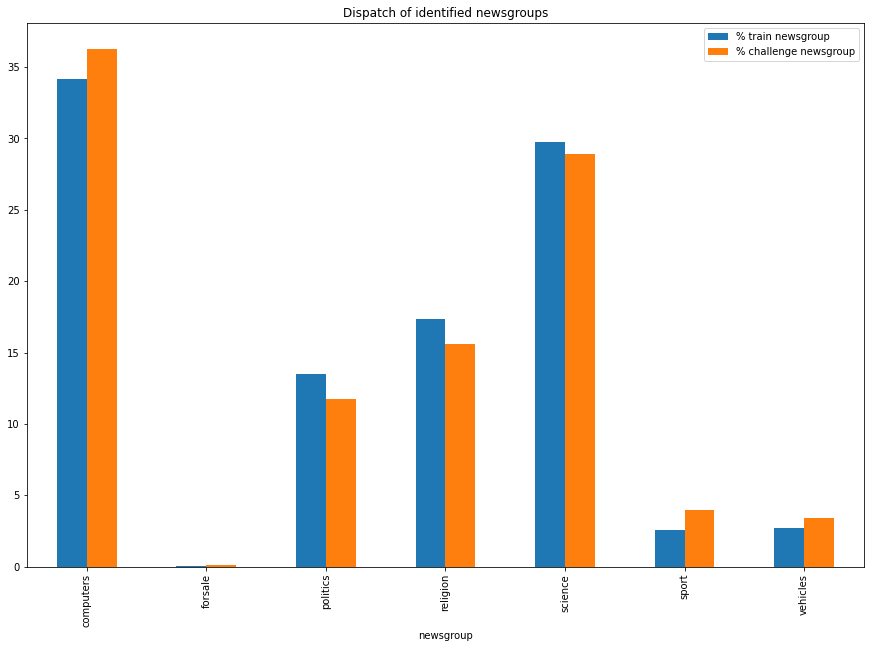

In [16]:
nb_newsgroup_90.plot(title='Dispatch of identified newsgroups',kind='bar',figsize=(15,10)).set_xlabel('newsgroup')



Text(0.5, 0, 'newsgroup')

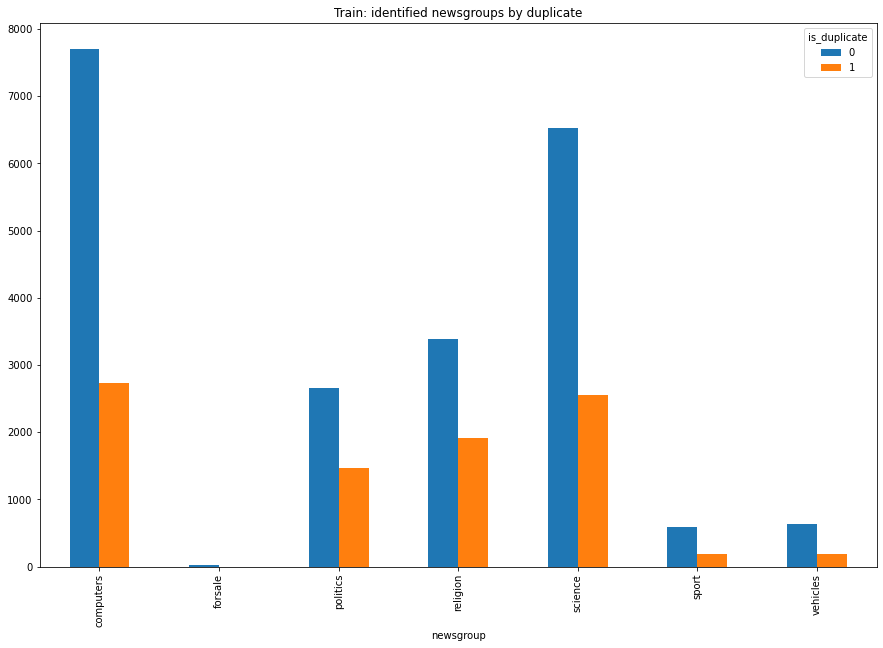

In [17]:
import altair
altair.data_transformers.disable_max_rows()
train_newsgroup_90.groupby(['newsgroup_1','is_duplicate']).size().unstack().plot(kind='bar',title='Train: identified newsgroups by duplicate',figsize=(15,10)).set_xlabel('newsgroup')

## Display wordclouds by newsgroups

** Note ** we supress category 'forsale' which is too unfrequent

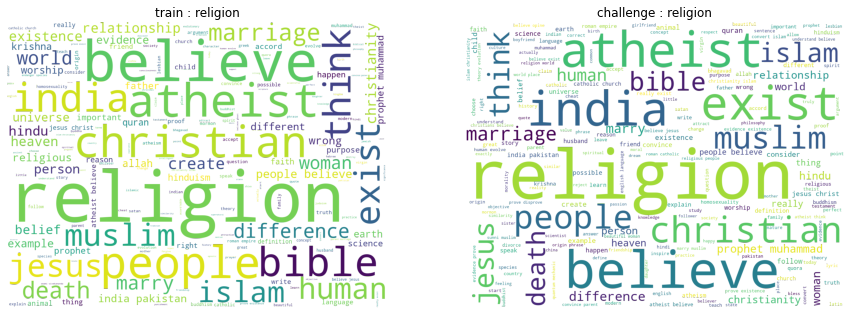

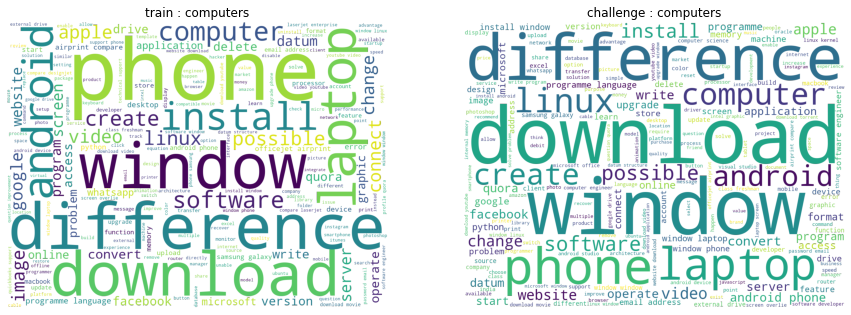

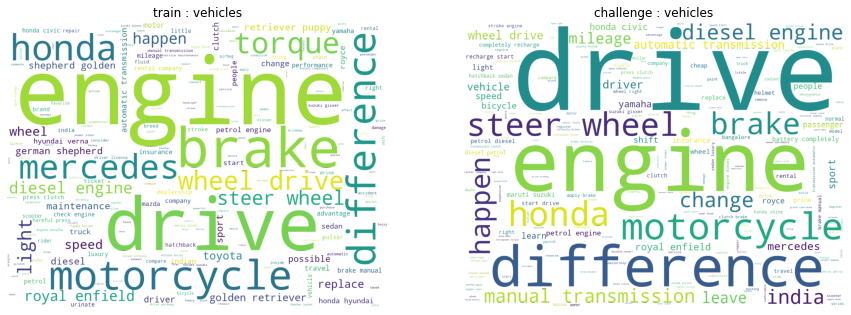

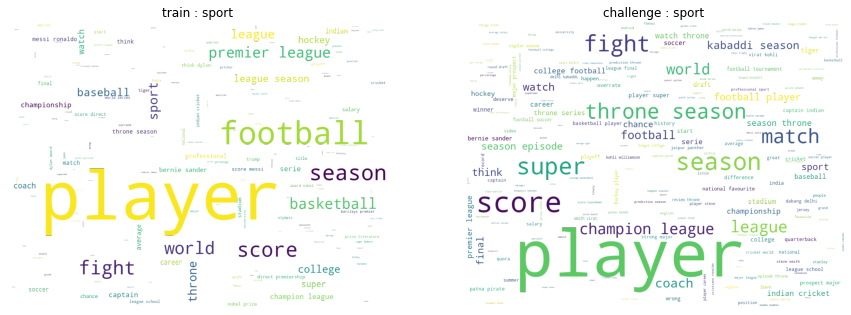

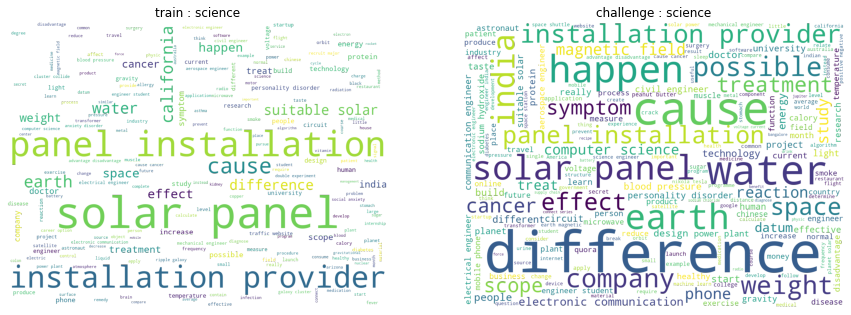

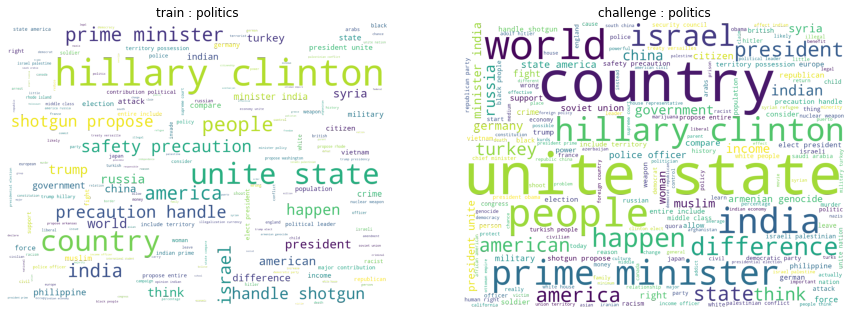

In [18]:
NEWSGROUP_LABELS=[
    'religion', #0
    'computers', #1
    'forsale', #2
    'vehicles', #3
    'sport', #4
    'science', #5
    'politics', #6
]

FREQUENT_NEWSGROUP_LABELS=[
    'religion', #0
    'computers', #1
    'vehicles', #3
    'sport', #4
    'science', #5
    'politics', #6
]

# display all wordclouds in one shot
def show_wordclouds_by_newsgroup(data):
    for n in FREQUENT_NEWSGROUP_LABELS:
        for t,d in data.items():
            yield
            one_newsgroup = d[d['newsgroup_1'] == n]
            cloud = WordCloud(
                width=1440,
                height=1080,
                stopwords=all_stop_words,
                background_color=None,
                mode='RGBA',
                relative_scaling=1,
                min_word_length=5
                ).generate(" ".join(one_newsgroup['lemmatized_question1']))
                #plot.figure(figsize=(15, 10))
            plot.title(t + " : " + n )
            plot.imshow(cloud)
            plot.axis('off')

DATA_90 = {
    'train': train_newsgroup_90,
    'challenge': challenge_newsgroup_90
}
        
def show_all_newsgroups_wordclouds(data,nb_columns=2):
    multiplot_from_generator(show_wordclouds_by_newsgroup(data), nb_columns)

show_all_newsgroups_wordclouds(DATA_90,2)

We have also another set of informations coming from spacy's analysis : entities.

Using spacy, we have extracted entities from these categories:
* **GPE**: Countries, cities, states
* **PERSON**: People, including fictional
* **PRODUCT**: Objects, vehicles, foods, etc. (not services)
* **ORG**: Companies, agencies, institutions, etc.'
* **DATE**: Absolute or relative dates or periods'
* **NORP**: Nationalities or religious or political groups'
* **WORK_OF_ART**: Titles of books, songs, etc.'
* **LANGUAGE**: Any named language'
* **EVENT**: Named hurricanes, battles, wars, sports events, etc.'
* **FAC**: Buildings, airports, highways, bridges, etc.'
* **LOC**: Non-GPE locations, mountain ranges, bodies of water'

Basically, all these entities (when well recognized) should be high level information on questions

What do we have in these categories of entities

In [19]:
TRACKED_ENTITIES =  {
    'GPE' : 'Countries, cities, states',
    'PERSON' : 'People, including fictional',
    'PRODUCT' : 'Objects, vehicles, foods, etc. (not services)',
    'ORG' : 'Companies, agencies, institutions, etc.',
    'DATE' : 'Absolute or relative dates or periods',
    'NORP' : 'Nationalities or religious or political groups',
    'WORK_OF_ART' : 'Titles of books, songs, etc.',
    'LANGUAGE' : 'Any named language',
    'EVENT' : 'Named hurricanes, battles, wars, sports events, etc.',
    'FAC' : 'Buildings, airports, highways, bridges, etc.',
    'LOC' : 'Non-GPE locations, mountain ranges, bodies of water'
 }

ALL_ENTITIES_COLUMNS=[c+'_question1' for c in TRACKED_ENTITIES.keys() if c+'_question1' in train_dataframe.columns]

train_dataframe[ALL_ENTITIES_COLUMNS]


GPE_question1 PERSON_question1 PRODUCT_question1 ORG_question1 DATE_question1 NORP_question1 WORK_OF_ART_question1 LANGUAGE_question1 EVENT_question1 FAC_question1 LOC_question1
0            [india]               []                []            []             []             []                    []                 []              []            []            []
1                 []               []                []    [kohinoor]             []             []                    []                 []              []            []            []
2                 []               []                []            []             []             []                    []                 []              []            []            []
3                 []               []                []            []             []             []                    []                 []              []            []            []
4                 []               []                []            []             []             []                    []                 []              []            []            []
...              ...              ...               ...           ...            ...            ...                   ...                ...             ...           ...           ...
404285            []               []                []            []             []             []                    []                 []              []            []            []
404286            []               []                []            []             []             []                    []                 []              []            []            []
404287            []               []                []            []             []             []                    []                 []              []            []            []
404288     [chicago]               []                []            []       [annual]       [indian]                    []                 []              []            []            []
404289            []               []                []            []             []             []                    []                 []              []            []            []

[404290 rows x 11 columns]

Quite sparce and not convenient

Let's merge all these informations so we can more easily build graphs from them

Start with simple counts

**Note** Detection of entities has been done on uncleaned text. We clean also the entities on-the-fly and stem them (stemming is ways faster than lemmatization and should be enough here)

In [38]:
import re
from nltk.stem import PorterStemmer

PORTER_STEMMER = PorterStemmer()
FINAL_PUNC_CLEANER = str.maketrans(dict([ (c,' ') for c in '!"#%&\'()*+,./:;<=>?[\\]^_`{|}~-']))

def clean_text(text):
    text = re.sub('\?',' ',text) # ?
    # odd chars
    # will generate more ' so do it first
    text = re.sub("’", "'", text) # special single quote
    text = re.sub("`", "'", text) # special single quote
    text = re.sub("“", '"', text) # special double quote
    text = re.sub("？", "?", text) 
    text = re.sub("…", " ", text) 
    text = re.sub("é", "e", text)
    
    # Quora is very used in India so roupie (rs) is often present
    text = re.sub("(?<=[0-9])rs ", " roupies ", text)
    text = re.sub(" rs(?=[0-9])", " roupies ", text)

    # stolen at kaggle : https://www.kaggle.com/currie32/the-importance-of-cleaning-text

    text = re.sub(r" uk ", " england ", text)
    text = re.sub(r" kms ", " kilometers ", text)
    text = re.sub(r" cs ", " computer science ", text) 
    text = re.sub(r" \0rs ", " roupies ", text)
    text = re.sub(r" calender ", " calendar ", text)
    text = re.sub(r" ios ", " operating system ", text)
    text = re.sub(r" programing ", " programming ", text)
    text = re.sub(r" banglore ", " bangalore ", text)
    
    # some others
    text = re.sub(r" usa ", " america ", text)
    text = re.sub(r" u s ", " america ", text)
    
    # units
    text = re.sub(r"\$(\d+)", lambda m: m.group(1) + ' dollar ', text)
    text = re.sub(r"(\d+)\$", lambda m: m.group(1) + ' dollar ', text)
    # This one is important in 2017
    text = re.sub(' donald trump',' trump ',text)
    text = re.sub(' dollars',' dollar ',text)
    text = re.sub(' quaro',' quora ',text)
    text = re.sub(r"googling", " google ", text)
    text = re.sub(r"googled", " google ", text)
    text = re.sub(r"googleable", " google ", text)
    text = re.sub(r"googles", " google ", text)
    
    text = re.sub(r"₹", " roupies ", text)   
    text = re.sub(r"\$", " dollar ", text)  
    
    # will blank any of !"#%&\'()*+,./:;<=>?[\\]^_`{|}~-
    # I keep the @ so emails won't vanish (?)
    # and $ is replaced by dollar before
    text = text.translate(FINAL_PUNC_CLEANER)
    return text

# we just join every kind of entities (at this time, there are stored as lists)
# and we do one bit more of cleaning
# followed by stemming 
def merge_all_entities(dataframe):
    for c in TRACKED_ENTITIES:
        print_warning('Merging all '+TRACKED_ENTITIES[c])
        add_column_from_column(dataframe,c+'_question1',c+'_question1',lambda l: clean_text(" ".join(l).lower()))
    return dataframe

train_dataframe = load_or_build_dataframe('Merge all entities in train','train_merged_entities',merge_all_entities,train_dataframe)
#challenge_dataframe = load_or_build_dataframe('Merge all entities in challenge','challenge_merged_entities',merge_all_entities,challenge_dataframe)

In [35]:
[PORTER_STEMMER.stem(w) for w in "Isn'it a greater day than yesterday".split()]
small = merge_all_entities(train_dataframe.sample(1000,random_state=42))
small[ALL_ENTITIES_COLUMNS]

GPE_question1 PERSON_question1 PRODUCT_question1 ORG_question1 DATE_question1 NORP_question1 WORK_OF_ART_question1 LANGUAGE_question1 EVENT_question1 FAC_question1 LOC_question1
8067           korea                                                                                                                                                                    
368101                                                                                                                                                                                  
70497                                                                                                                                                                                   
226567                                                                                                                                                                                  
73186                                                                                                                                          3rd world war                            
...              ...              ...               ...           ...            ...            ...                   ...                ...             ...           ...           ...
259840                          quora                                                                                                                                                   
169324                                                                                                                                                                                  
5761                                                                                                                                                                                    
63759                                                       idbi bank                                                                                                                   
80013                                                                                                                                                                                   

[1000 rows x 11 columns]

In [ ]:
def count_question1_with_entities(dataframe):
    res = dict()
    for c in TRACKED_ENTITIES:
        res[TRACKED_ENTITIES[c]] = 100.*dataframe[dataframe[c+'_question1'].str.len()>0][c+'_question1'].count()/len(dataframe)
    return res

rows_with_entities = pandas.DataFrame.from_dict(count_question1_with_entities(train_dataframe),orient="index",columns=['train'])
rows_with_entities['challenge'] = count_question1_with_entities(challenge_dataframe).values()
rows_with_entities.plot(title='questions with entities',kind='barh',figsize=(10,7)).set_xlabel('%')

We don't have so much entities but let's see what we have for each kind of entity

Just start with all entities

In [ ]:
all_entities=''
def merge_all_entities(dataframe): 
    all_entities = ''   
    for c in TRACKED_ENTITIES:
        all_entities = all_entities + " ".join(dataframe[c+'_question1'])
    return all_entities

cloud = WordCloud(
                width=1440,
                height=1080,
                stopwords=all_stop_words, # entities should not be in stop words. I keep that
                background_color=None,
                mode='RGBA',
                relative_scaling=.5,
                min_word_length=5,
                collocations=False,
                repeat=False
                ).generate(merge_all_entities(train_dataframe))
plot.figure(figsize=(20, 15))
plot.title("train: all entities" )
plot.imshow(cloud)
plot.axis('off')


Hum
We would need also to apply a stemmer to spacy's entities ...

Let's show wordclouds for each kind of entities

In [ ]:
def show_all_entities_by_kind(datasets):
    for e in TRACKED_ENTITIES:
        for d in datasets:            
            yield
            cloud = WordCloud(
                        width=1440,
                        height=1080,
                        stopwords=all_stop_words, # entities should not be in stop words. I keep that
                        background_color=None,
                        mode='RGBA',
                        relative_scaling=0.5,
                        collocations=False,
                        repeat=False,
                        min_word_length=5
                        ).generate(" ".join(datasets[d][e+'_question1']))
            plot.title(d +' : '+TRACKED_ENTITIES[e] )
            plot.imshow(cloud)
            plot.axis('off')


DATASETS={
    'Train':train_dataframe,
    'Challenge':challenge_dataframe
}

def show_all_entities_wordclouds(datasets,nb_columns=2):
    multiplot_from_generator(show_all_entities_by_kind(datasets), nb_columns)
show_all_entities_wordclouds(DATASETS,2)

We can cross-reference our 2 sources of high level information

* WHO is referenced in questions about 'politics' ?
* WHICH products are referenced in 'computers' ?


In [ ]:

words = " ".join(train_dataframe[train_dataframe['newsgroup_1']=='politics']['PERSON_question1'])
# I do some minor tweaks : spacy has detected sometimes strange entities
words = words.replace('quora','').replace('hillary','clinton')
cloud = WordCloud(
                width=1440,
                height=1080,
                stopwords=all_stop_words, # entities should not be in stop words. I keep that
                background_color=None,
                mode='RGBA',
                relative_scaling=0.5,
                collocations=False,
                repeat=False,
                min_word_length=5
                ).generate(words)
plot.figure(figsize=(20, 15))
plot.title("Who in 'politics'" )
plot.imshow(cloud)
plot.axis('off')


In [ ]:
words = " ".join(train_dataframe[train_dataframe['newsgroup_1']=='computers']['PRODUCT_question1'])
cloud = WordCloud(
                width=1440,
                height=1080,
                stopwords=all_stop_words, # entities should not be in stop words. I keep that
                background_color=None,
                mode='RGBA',
                relative_scaling=0.5,
                collocations=False,
                repeat=False,
                min_word_length=5
                ).generate(words)
plot.figure(figsize=(20, 15))
plot.title("What product in 'computers'" )
plot.imshow(cloud)
plot.axis('off')

We can get back to the original questions

Here we display what words are associated to product 'camera' in newsgroup 'computers'

In [ ]:
words = train_dataframe[train_dataframe['newsgroup_1']=='computers']
words = words[words['PRODUCT_question1'].str.contains('camera')]
cloud = WordCloud(
                width=1440,
                height=1080,
                stopwords=all_stop_words, # entities should not be in stop words. I keep that
                background_color=None,
                mode='RGBA',
                relative_scaling=0.5,
                collocations=False,
                repeat=False,
                min_word_length=5
                ).generate(" ".join(words['question1']))
plot.figure(figsize=(20, 15))
plot.title("Who in 'politics'" )
plot.imshow(cloud)
plot.axis('off')


#train_dataframe[train_dataframe['PERSON_question1']=='hitler']['PERSON_question1'].count()

In [ ]:
Which words are used in 'politics' when asking about 'trump'

In [ ]:
words = train_dataframe[train_dataframe['newsgroup_1']=='politics']
words = words[words['PERSON_question1'].str.contains('trump')]

cloud = WordCloud(
                width=1440,
                height=1080,
                stopwords=all_stop_words, # entities should not be in stop words. I keep that
                background_color=None,
                mode='RGBA',
                relative_scaling=0.5,
                collocations=False,
                repeat=False,
                min_word_length=5
                ).generate(" ".join(words['question1']))
plot.figure(figsize=(20, 15))
plot.title("Who in 'politics'" )
plot.imshow(cloud)
plot.axis('off')